# Experimentación - DyGrEncoder



## 1. Obtención de datos



In [2]:

import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
import itertools
import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid


from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch

from utils.models import DyGrEncoderModel
from utils.trainer import  TrainerDryGrEncoder
from utils.utils_graph import *
dtype = torch.float
device = torch.device("cpu")

In [3]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import MPNNLSTMModel

In [4]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [5]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [68]:
def entrenar_y_evaluar_modelos_dygrencoder(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="Classification", name=None, target_names=None, device=torch.device("cpu")):
    resultados_list = []

    # Variables para guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    # Detalles del dataset
    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[0]
    n_features = dataset[0].x.shape[1]


    for aggr, conv, lstm, out_lstm in tqdm(list(itertools.product(param_grid["aggr"], param_grid["conv"], param_grid["lstm"],  param_grid['out_lstm']))):
        
        print(f"Entrenando modelo con aggr={aggr}, conv={conv}, lstm={lstm},out_lstm={out_lstm}")

        model = DyGrEncoderModel(node_features=n_features, node_count=n_nodes,num_conv=conv, num_lstm=lstm, aggr=aggr,lstm_out =out_lstm, n_target=n_target, name="DyGrEncoder", is_classification=True)
        trainer = TrainerDryGrEncoder(model, dataset, device, f"./results/{problem}", dataloader_params, is_classification = True)

        losses, eval_losses, accs, precisions, recalls, f1s = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer.test()

        results_intermedio = {
            "Aggr": aggr,
            "Conv": conv,
            "LSTM": lstm,
            "LSTM_out": out_lstm,
            "Loss_final": losses[-1],  # Usando el último valor de la lista, si es consistente con tus datos
            "Accuracy_eval": np.mean(accs),
            "Precision_eval": np.mean(precisions),
            "Recall_eval": np.mean(recalls),
            "F1_eval": np.mean(f1s),
            "Loss_eval": np.mean(eval_losses[-1]),  # Asumiendo que tienes evaluaciones periódicas como en regresión
            "Loss_tst": np.mean(test_loss),
            "Accuracy_tst": test_acc,
            "Precision_tst": test_precision,
            "Recall_tst": test_recall,
            "F1_tst": test_f1
        }
        
        resultados_list.append(results_intermedio)

        # Actualizar el mejor modelo si es necesario
        if np.mean(test_loss) < mejor_loss_test:
            mejor_loss_test = np.mean(test_loss)
            mejor_trainer = trainer
            mejores_parametros = {'aggr': aggr, 'conv': conv, 'lstm': lstm, 'lstm_out': out_lstm}
            mejores_resultados = results_intermedio

        print("Parámetros: ", aggr, conv, lstm, out_lstm)
        print("Resultados: ", resultados_list[-1])

    resultados_df = pd.DataFrame(resultados_list)
    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_df


## Bucle rápido para ajustar y guardar resultados

In [72]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import DyGrEncoderModel

In [73]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerDryGrEncoder

In [74]:

param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2],
    "out_lstm": [ 800,850, 900], #Number of input channels has to be smaller than number of output channels
}

dataloader_params = {
    "batch_size": 4,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": True
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos_dygrencoder(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "DyGrEncoder",target_names)

  0%|          | 0/24 [00:00<?, ?it/s]

Entrenando modelo con aggr=add, conv=1, lstm=1,out_lstm=800

==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5094 | Eval Loss: 1.3422 | Accuracy: 0.6133 | Precision: 0.4379 | Recall: 0.4731 | F1-Score: 0.4513 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.3520 | Eval Loss: 1.2909 | Accuracy: 0.6133 | Precision: 0.3408 | Recall: 0.4993 | F1-Score: 0.3994 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.3080 | Eval Loss: 1.2959 | Accuracy: 0.6133 | Precision: 0.4894 | Recall: 0.5198 | F1-Score: 0.4489 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.2761 | Eval Loss: 1.2997 | Accuracy: 0.6400 | Precision: 0.5623 | Recall: 0.5484 | F1-Score: 0.4821 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.2699 | Eval Loss: 1.2944 | Accuracy: 0.5867 | Precision: 0.4264 | Recall: 0.4855 | F1-Score: 0.4485 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 1.2565 | Eval Loss: 1.289

  4%|▍         | 1/24 [05:27<2:05:28, 327.34s/it]

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.40      0.67      0.50        15
           2       0.27      0.33      0.30         9
           3       0.25      0.05      0.09        19
           4       0.76      0.90      0.83        29

    accuracy                           0.55        84
   macro avg       0.46      0.49      0.45        84
weighted avg       0.51      0.55      0.50        84

preds:  torch.Size([])
test loss: 1.329544, test accuracy: 0.5476, test precision: 0.4575, test recall: 0.4898, test F1-score: 0.4516
Parámetros:  add 1 1 800
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'LSTM_out': 800, 'Loss_final': 1.0163146257400513, 'Accuracy_eval': 0.6266666666666667, 'Precision_eval': 0.5081028438121338, 'Recall_eval': 0.523841890867753, 'F1_eval': 0.4983369168066949, 'Loss_eval': 1.2552554607391357, 'Loss_tst': 1.3295443058013916, 'Accuracy_tst': 0.5476190476190477, 'Precisio

  8%|▊         | 2/24 [11:26<2:06:50, 345.94s/it]

              precision    recall  f1-score   support

           0       0.56      0.42      0.48        12
           1       0.36      0.53      0.43        15
           2       0.30      0.33      0.32         9
           3       0.36      0.21      0.27        19
           4       0.72      0.79      0.75        29

    accuracy                           0.51        84
   macro avg       0.46      0.46      0.45        84
weighted avg       0.51      0.51      0.50        84

preds:  torch.Size([])
test loss: 1.350512, test accuracy: 0.5119, test precision: 0.4603, test recall: 0.4574, test F1-score: 0.4490
Parámetros:  add 1 1 850
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'LSTM_out': 850, 'Loss_final': 1.069093942642212, 'Accuracy_eval': 0.6210256410256411, 'Precision_eval': 0.5239558000714588, 'Recall_eval': 0.5215574081091323, 'F1_eval': 0.49673172663043325, 'Loss_eval': 1.255673885345459, 'Loss_tst': 1.350512146949768, 'Accuracy_tst': 0.5119047619047619, 'Precision

 12%|█▎        | 3/24 [17:28<2:03:39, 353.31s/it]

              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.35      0.73      0.48        15
           2       0.33      0.33      0.33         9
           3       0.00      0.00      0.00        19
           4       0.77      0.83      0.80        29

    accuracy                           0.54        84
   macro avg       0.42      0.50      0.44        84
weighted avg       0.46      0.54      0.48        84

preds:  torch.Size([])
test loss: 1.352798, test accuracy: 0.5357, test precision: 0.4197, test recall: 0.4955, test F1-score: 0.4441
Parámetros:  add 1 1 900
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'LSTM_out': 900, 'Loss_final': 1.0325795412063599, 'Accuracy_eval': 0.6197435897435898, 'Precision_eval': 0.48979388786268446, 'Recall_eval': 0.5170353353543008, 'F1_eval': 0.48477818747057355, 'Loss_eval': 1.2601970434188843, 'Loss_tst': 1.3527977466583252, 'Accuracy_tst': 0.5357142857142857, 'Preci

 17%|█▋        | 4/24 [26:09<2:19:49, 419.47s/it]

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.32      0.73      0.45        15
           2       0.40      0.22      0.29         9
           3       0.29      0.11      0.15        19
           4       0.79      0.66      0.72        29

    accuracy                           0.52        84
   macro avg       0.50      0.51      0.47        84
weighted avg       0.54      0.52      0.50        84

preds:  torch.Size([])
test loss: 1.367285, test accuracy: 0.5238, test precision: 0.5030, test recall: 0.5099, test F1-score: 0.4750
Parámetros:  add 1 2 800
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'LSTM_out': 800, 'Loss_final': 1.1342536211013794, 'Accuracy_eval': 0.5979487179487178, 'Precision_eval': 0.47940821883233536, 'Recall_eval': 0.4996452254641909, 'F1_eval': 0.46843373909701636, 'Loss_eval': 1.2954282760620117, 'Loss_tst': 1.3672845363616943, 'Accuracy_tst': 0.5238095238095238, 'Preci

 21%|██        | 5/24 [36:04<2:32:50, 482.68s/it]

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.31      0.53      0.39        15
           2       0.29      0.44      0.35         9
           3       0.25      0.05      0.09        19
           4       0.79      0.76      0.77        29

    accuracy                           0.51        84
   macro avg       0.46      0.49      0.45        84
weighted avg       0.51      0.51      0.49        84

preds:  torch.Size([])
test loss: 1.345876, test accuracy: 0.5119, test precision: 0.4592, test recall: 0.4911, test F1-score: 0.4527
Parámetros:  add 1 2 850
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'LSTM_out': 850, 'Loss_final': 1.0784937143325806, 'Accuracy_eval': 0.6023076923076923, 'Precision_eval': 0.521821913908979, 'Recall_eval': 0.5060193255020842, 'F1_eval': 0.4811950387360564, 'Loss_eval': 1.291514277458191, 'Loss_tst': 1.3458757400512695, 'Accuracy_tst': 0.5119047619047619, 'Precision

 25%|██▌       | 6/24 [46:29<2:39:19, 531.08s/it]

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.37      0.73      0.49        15
           2       0.25      0.11      0.15         9
           3       0.50      0.16      0.24        19
           4       0.80      0.83      0.81        29

    accuracy                           0.57        84
   macro avg       0.51      0.52      0.48        84
weighted avg       0.57      0.57      0.54        84

preds:  torch.Size([])
test loss: 1.330824, test accuracy: 0.5714, test precision: 0.5119, test recall: 0.5160, test F1-score: 0.4777
Parámetros:  add 1 2 900
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'LSTM_out': 900, 'Loss_final': 1.0833632946014404, 'Accuracy_eval': 0.5946153846153847, 'Precision_eval': 0.47544278241286736, 'Recall_eval': 0.49653135657446, 'F1_eval': 0.46178665237627603, 'Loss_eval': 1.2650500535964966, 'Loss_tst': 1.3308241367340088, 'Accuracy_tst': 0.5714285714285714, 'Precisi

 29%|██▉       | 7/24 [56:09<2:35:01, 547.14s/it]

              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.44      0.53      0.48        15
           2       0.40      0.44      0.42         9
           3       0.50      0.37      0.42        19
           4       0.72      0.79      0.75        29

    accuracy                           0.58        84
   macro avg       0.55      0.54      0.54        84
weighted avg       0.58      0.58      0.58        84

preds:  torch.Size([])
test loss: 1.332177, test accuracy: 0.5833, test precision: 0.5526, test recall: 0.5445, test F1-score: 0.5441
Parámetros:  add 2 1 800
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'LSTM_out': 800, 'Loss_final': 1.0154131650924683, 'Accuracy_eval': 0.6176923076923078, 'Precision_eval': 0.5031011301441235, 'Recall_eval': 0.5113205759757483, 'F1_eval': 0.4856228643016677, 'Loss_eval': 1.2818864583969116, 'Loss_tst': 1.3321772813796997, 'Accuracy_tst': 0.5833333333333334, 'Precisi

 33%|███▎      | 8/24 [1:06:21<2:31:26, 567.90s/it]

              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.38      0.73      0.50        15
           2       0.38      0.33      0.35         9
           3       0.14      0.05      0.08        19
           4       0.77      0.79      0.78        29

    accuracy                           0.54        84
   macro avg       0.47      0.50      0.47        84
weighted avg       0.50      0.54      0.50        84

preds:  torch.Size([])
test loss: 1.334767, test accuracy: 0.5357, test precision: 0.4728, test recall: 0.4991, test F1-score: 0.4692
Parámetros:  add 2 1 850
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'LSTM_out': 850, 'Loss_final': 1.0176070928573608, 'Accuracy_eval': 0.6258974358974358, 'Precision_eval': 0.49347393151216984, 'Recall_eval': 0.5181242895035998, 'F1_eval': 0.49046664431373344, 'Loss_eval': 1.2601683139801025, 'Loss_tst': 1.33476722240448, 'Accuracy_tst': 0.5357142857142857, 'Precisi

 38%|███▊      | 9/24 [1:16:10<2:23:37, 574.51s/it]

              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.33      0.53      0.41        15
           2       0.33      0.44      0.38         9
           3       0.00      0.00      0.00        19
           4       0.76      0.86      0.81        29

    accuracy                           0.52        84
   macro avg       0.42      0.48      0.45        84
weighted avg       0.46      0.52      0.48        84

preds:  torch.Size([])
test loss: 1.355708, test accuracy: 0.5238, test precision: 0.4248, test recall: 0.4846, test F1-score: 0.4468
Parámetros:  add 2 1 900
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'LSTM_out': 900, 'Loss_final': 0.9907599687576294, 'Accuracy_eval': 0.6133333333333333, 'Precision_eval': 0.48144482985728754, 'Recall_eval': 0.5029727169382343, 'F1_eval': 0.47575566181117346, 'Loss_eval': 1.2649471759796143, 'Loss_tst': 1.3557080030441284, 'Accuracy_tst': 0.5238095238095238, 'Preci

 42%|████▏     | 10/24 [1:27:31<2:21:43, 607.39s/it]

              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.33      0.67      0.44        15
           2       0.29      0.22      0.25         9
           3       0.25      0.11      0.15        19
           4       0.75      0.72      0.74        29

    accuracy                           0.50        84
   macro avg       0.45      0.46      0.44        84
weighted avg       0.50      0.50      0.48        84

preds:  torch.Size([])
test loss: 1.409290, test accuracy: 0.5000, test precision: 0.4511, test recall: 0.4603, test F1-score: 0.4376
Parámetros:  add 2 2 800
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'LSTM_out': 800, 'Loss_final': 1.087217926979065, 'Accuracy_eval': 0.6025641025641026, 'Precision_eval': 0.4901365115893033, 'Recall_eval': 0.5029911898446382, 'F1_eval': 0.471892301025893, 'Loss_eval': 1.3037190437316895, 'Loss_tst': 1.4092897176742554, 'Accuracy_tst': 0.5, 'Precision_tst': 0.451082

 46%|████▌     | 11/24 [1:40:24<2:22:35, 658.12s/it]

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.41      0.80      0.55        15
           2       0.33      0.22      0.27         9
           3       0.20      0.05      0.08        19
           4       0.79      0.79      0.79        29

    accuracy                           0.56        84
   macro avg       0.47      0.52      0.47        84
weighted avg       0.51      0.56      0.51        84

preds:  torch.Size([])
test loss: 1.343284, test accuracy: 0.5595, test precision: 0.4680, test recall: 0.5236, test F1-score: 0.4710
Parámetros:  add 2 2 850
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'LSTM_out': 850, 'Loss_final': 1.0948878526687622, 'Accuracy_eval': 0.5794871794871794, 'Precision_eval': 0.4673549895914392, 'Recall_eval': 0.4855357142857141, 'F1_eval': 0.4525366948770818, 'Loss_eval': 1.299035906791687, 'Loss_tst': 1.3432843685150146, 'Accuracy_tst': 0.5595238095238095, 'Precisio

 50%|█████     | 12/24 [1:54:21<2:22:28, 712.36s/it]

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.41      0.73      0.52        15
           2       0.22      0.22      0.22         9
           3       1.00      0.05      0.10        19
           4       0.73      0.93      0.82        29

    accuracy                           0.56        84
   macro avg       0.59      0.49      0.44        84
weighted avg       0.66      0.56      0.50        84

preds:  torch.Size([])
test loss: 1.346402, test accuracy: 0.5595, test precision: 0.5919, test recall: 0.4878, test F1-score: 0.4419
Parámetros:  add 2 2 900
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'LSTM_out': 900, 'Loss_final': 1.087317705154419, 'Accuracy_eval': 0.6074358974358974, 'Precision_eval': 0.5365677414335959, 'Recall_eval': 0.5194851269420235, 'F1_eval': 0.4960879593483896, 'Loss_eval': 1.2715829610824585, 'Loss_tst': 1.3464021682739258, 'Accuracy_tst': 0.5595238095238095, 'Precisio

 54%|█████▍    | 13/24 [2:00:32<1:51:38, 608.93s/it]

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.43      0.60      0.50        15
           2       0.44      0.44      0.44         9
           3       0.56      0.26      0.36        19
           4       0.74      0.86      0.79        29

    accuracy                           0.61        84
   macro avg       0.58      0.57      0.56        84
weighted avg       0.61      0.61      0.59        84

preds:  torch.Size([])
test loss: 1.296082, test accuracy: 0.6071, test precision: 0.5782, test recall: 0.5673, test F1-score: 0.5582
Parámetros:  mean 1 1 800
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'LSTM_out': 800, 'Loss_final': 1.0133885145187378, 'Accuracy_eval': 0.6397435897435897, 'Precision_eval': 0.5474031690437263, 'Recall_eval': 0.5360164835164836, 'F1_eval': 0.5134393969054734, 'Loss_eval': 1.2137041091918945, 'Loss_tst': 1.2960824966430664, 'Accuracy_tst': 0.6071428571428571, 'Preci

 58%|█████▊    | 14/24 [2:06:14<1:28:04, 528.42s/it]

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        12
           1       0.38      0.67      0.49        15
           2       0.30      0.33      0.32         9
           3       0.57      0.21      0.31        19
           4       0.75      0.83      0.79        29

    accuracy                           0.56        84
   macro avg       0.53      0.51      0.49        84
weighted avg       0.58      0.56      0.54        84

preds:  torch.Size([])
test loss: 1.335266, test accuracy: 0.5595, test precision: 0.5345, test recall: 0.5076, test F1-score: 0.4939
Parámetros:  mean 1 1 850
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'LSTM_out': 850, 'Loss_final': 1.0024833679199219, 'Accuracy_eval': 0.6423076923076922, 'Precision_eval': 0.5556125761971829, 'Recall_eval': 0.5370367563471011, 'F1_eval': 0.5191807535472064, 'Loss_eval': 1.2800781726837158, 'Loss_tst': 1.335265874862671, 'Accuracy_tst': 0.5595238095238095, 'Precis

 62%|██████▎   | 15/24 [2:12:40<1:12:48, 485.37s/it]

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.38      0.67      0.49        15
           2       0.40      0.22      0.29         9
           3       0.29      0.11      0.15        19
           4       0.75      0.83      0.79        29

    accuracy                           0.57        84
   macro avg       0.51      0.53      0.50        84
weighted avg       0.54      0.57      0.53        84

preds:  torch.Size([])
test loss: 1.313837, test accuracy: 0.5714, test precision: 0.5069, test recall: 0.5310, test F1-score: 0.4967
Parámetros:  mean 1 1 900
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'LSTM_out': 900, 'Loss_final': 1.027050495147705, 'Accuracy_eval': 0.6230769230769232, 'Precision_eval': 0.47398547431344934, 'Recall_eval': 0.5100004736642668, 'F1_eval': 0.47742697636536574, 'Loss_eval': 1.2538886070251465, 'Loss_tst': 1.313836693763733, 'Accuracy_tst': 0.5714285714285714, 'Preci

 67%|██████▋   | 16/24 [2:21:47<1:07:13, 504.16s/it]

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.39      0.80      0.52        15
           2       0.20      0.11      0.14         9
           3       0.00      0.00      0.00        19
           4       0.76      0.90      0.83        29

    accuracy                           0.57        84
   macro avg       0.40      0.51      0.44        84
weighted avg       0.45      0.57      0.49        84

preds:  torch.Size([])
test loss: 1.321662, test accuracy: 0.5714, test precision: 0.3989, test recall: 0.5115, test F1-score: 0.4365
Parámetros:  mean 1 2 800
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'LSTM_out': 800, 'Loss_final': 1.1221727132797241, 'Accuracy_eval': 0.5958974358974359, 'Precision_eval': 0.47813851386317957, 'Recall_eval': 0.49261557408109125, 'F1_eval': 0.457789347055944, 'Loss_eval': 1.2831307649612427, 'Loss_tst': 1.3216619491577148, 'Accuracy_tst': 0.5714285714285714, 'Prec

 71%|███████   | 17/24 [2:30:28<59:23, 509.09s/it]  

              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.39      0.73      0.51        15
           2       0.25      0.22      0.24         9
           3       0.14      0.05      0.08        19
           4       0.73      0.76      0.75        29

    accuracy                           0.51        84
   macro avg       0.43      0.47      0.44        84
weighted avg       0.47      0.51      0.48        84

preds:  torch.Size([])
test loss: 1.361353, test accuracy: 0.5119, test precision: 0.4311, test recall: 0.4700, test F1-score: 0.4357
Parámetros:  mean 1 2 850
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'LSTM_out': 850, 'Loss_final': 1.063355565071106, 'Accuracy_eval': 0.5971794871794871, 'Precision_eval': 0.5143905563320422, 'Recall_eval': 0.5210884804850322, 'F1_eval': 0.4963426380590586, 'Loss_eval': 1.294084072113037, 'Loss_tst': 1.3613531589508057, 'Accuracy_tst': 0.5119047619047619, 'Precisi

 75%|███████▌  | 18/24 [2:39:18<51:31, 515.25s/it]

              precision    recall  f1-score   support

           0       0.62      0.42      0.50        12
           1       0.44      0.53      0.48        15
           2       0.31      0.56      0.40         9
           3       0.25      0.05      0.09        19
           4       0.74      0.97      0.84        29

    accuracy                           0.56        84
   macro avg       0.47      0.50      0.46        84
weighted avg       0.51      0.56      0.51        84

preds:  torch.Size([])
test loss: 1.307437, test accuracy: 0.5595, test precision: 0.4738, test recall: 0.5047, test F1-score: 0.4615
Parámetros:  mean 1 2 900
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'LSTM_out': 900, 'Loss_final': 1.1090408563613892, 'Accuracy_eval': 0.5928205128205127, 'Precision_eval': 0.5014386318975824, 'Recall_eval': 0.4928723001136795, 'F1_eval': 0.46233140927336575, 'Loss_eval': 1.2845083475112915, 'Loss_tst': 1.3074373006820679, 'Accuracy_tst': 0.5595238095238095, 'Prec

 79%|███████▉  | 19/24 [2:47:37<42:32, 510.54s/it]

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.36      0.67      0.47        15
           2       0.43      0.33      0.38         9
           3       0.17      0.05      0.08        19
           4       0.74      0.79      0.77        29

    accuracy                           0.54        84
   macro avg       0.47      0.50      0.47        84
weighted avg       0.50      0.54      0.50        84

preds:  torch.Size([])
test loss: 1.347917, test accuracy: 0.5357, test precision: 0.4722, test recall: 0.5025, test F1-score: 0.4707
Parámetros:  mean 2 1 800
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'LSTM_out': 800, 'Loss_final': 0.9752752780914307, 'Accuracy_eval': 0.6407692307692306, 'Precision_eval': 0.5122324047486186, 'Recall_eval': 0.5322641151951497, 'F1_eval': 0.5079592892903462, 'Loss_eval': 1.218258023262024, 'Loss_tst': 1.347917079925537, 'Accuracy_tst': 0.5357142857142857, 'Precisi

 83%|████████▎ | 20/24 [2:55:30<33:16, 499.07s/it]

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.39      0.73      0.51        15
           2       0.38      0.33      0.35         9
           3       0.29      0.11      0.15        19
           4       0.74      0.79      0.77        29

    accuracy                           0.54        84
   macro avg       0.48      0.49      0.47        84
weighted avg       0.52      0.54      0.51        84

preds:  torch.Size([])
test loss: 1.354858, test accuracy: 0.5357, test precision: 0.4791, test recall: 0.4930, test F1-score: 0.4661
Parámetros:  mean 2 1 850
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'LSTM_out': 850, 'Loss_final': 0.9822741746902466, 'Accuracy_eval': 0.6246153846153847, 'Precision_eval': 0.4786391754588592, 'Recall_eval': 0.5069747063281546, 'F1_eval': 0.47934684793913906, 'Loss_eval': 1.2378281354904175, 'Loss_tst': 1.354858160018921, 'Accuracy_tst': 0.5357142857142857, 'Preci

 88%|████████▊ | 21/24 [3:03:50<24:58, 499.57s/it]

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.47      0.53      0.50        15
           2       0.43      0.33      0.38         9
           3       0.54      0.37      0.44        19
           4       0.74      0.90      0.81        29

    accuracy                           0.63        84
   macro avg       0.59      0.58      0.57        84
weighted avg       0.62      0.63      0.62        84

preds:  torch.Size([])
test loss: 1.278305, test accuracy: 0.6310, test precision: 0.5861, test recall: 0.5763, test F1-score: 0.5750
Parámetros:  mean 2 1 900
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'LSTM_out': 900, 'Loss_final': 1.0191569328308105, 'Accuracy_eval': 0.6312820512820512, 'Precision_eval': 0.5164558924712327, 'Recall_eval': 0.5255991852974612, 'F1_eval': 0.5047083634608762, 'Loss_eval': 1.244017243385315, 'Loss_tst': 1.278305172920227, 'Accuracy_tst': 0.6309523809523809, 'Precisi

 92%|█████████▏| 22/24 [3:13:55<17:42, 531.08s/it]

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.31      0.60      0.41        15
           2       0.14      0.11      0.12         9
           3       0.33      0.11      0.16        19
           4       0.81      0.72      0.76        29

    accuracy                           0.51        84
   macro avg       0.44      0.47      0.43        84
weighted avg       0.51      0.51      0.49        84

preds:  torch.Size([])
test loss: 1.352933, test accuracy: 0.5119, test precision: 0.4438, test recall: 0.4748, test F1-score: 0.4344
Parámetros:  mean 2 2 800
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'LSTM_out': 800, 'Loss_final': 1.074155569076538, 'Accuracy_eval': 0.5917948717948718, 'Precision_eval': 0.4658408489214176, 'Recall_eval': 0.493711159530125, 'F1_eval': 0.4626487726647558, 'Loss_eval': 1.2665330171585083, 'Loss_tst': 1.3529326915740967, 'Accuracy_tst': 0.5119047619047619, 'Precisi

 96%|█████████▌| 23/24 [3:25:52<09:46, 586.88s/it]

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.33      0.73      0.46        15
           2       0.43      0.33      0.38         9
           3       0.40      0.11      0.17        19
           4       0.81      0.76      0.79        29

    accuracy                           0.56        84
   macro avg       0.55      0.54      0.51        84
weighted avg       0.58      0.56      0.54        84

preds:  torch.Size([])
test loss: 1.336611, test accuracy: 0.5595, test precision: 0.5453, test recall: 0.5361, test F1-score: 0.5071
Parámetros:  mean 2 2 850
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'LSTM_out': 850, 'Loss_final': 1.0704625844955444, 'Accuracy_eval': 0.5871794871794872, 'Precision_eval': 0.4864313578751152, 'Recall_eval': 0.5000573133762789, 'F1_eval': 0.468730602673971, 'Loss_eval': 1.3622488975524902, 'Loss_tst': 1.336611032485962, 'Accuracy_tst': 0.5595238095238095, 'Precisi

100%|██████████| 24/24 [3:37:37<00:00, 544.07s/it]

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.50      0.67      0.57        15
           2       0.18      0.22      0.20         9
           3       0.25      0.05      0.09        19
           4       0.72      0.97      0.82        29

    accuracy                           0.56        84
   macro avg       0.45      0.48      0.45        84
weighted avg       0.50      0.56      0.51        84

preds:  torch.Size([])
test loss: 1.303308, test accuracy: 0.5595, test precision: 0.4500, test recall: 0.4814, test F1-score: 0.4455
Parámetros:  mean 2 2 900
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'LSTM_out': 900, 'Loss_final': 1.05661141872406, 'Accuracy_eval': 0.5956410256410256, 'Precision_eval': 0.4975411878106985, 'Recall_eval': 0.5017009283819628, 'F1_eval': 0.47375615706801394, 'Loss_eval': 1.2693215608596802, 'Loss_tst': 1.303308129310608, 'Accuracy_tst': 0.5595238095238095, 'Precisi


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.47      0.53      0.50        15
           2       0.43      0.33      0.38         9
           3       0.54      0.37      0.44        19
           4       0.74      0.90      0.81        29

    accuracy                           0.63        84
   macro avg       0.59      0.58      0.57        84
weighted avg       0.62      0.63      0.62        84

preds:  torch.Size([])
test loss: 1.278305, test accuracy: 0.6310, test precision: 0.5861, test recall: 0.5763, test F1-score: 0.5750


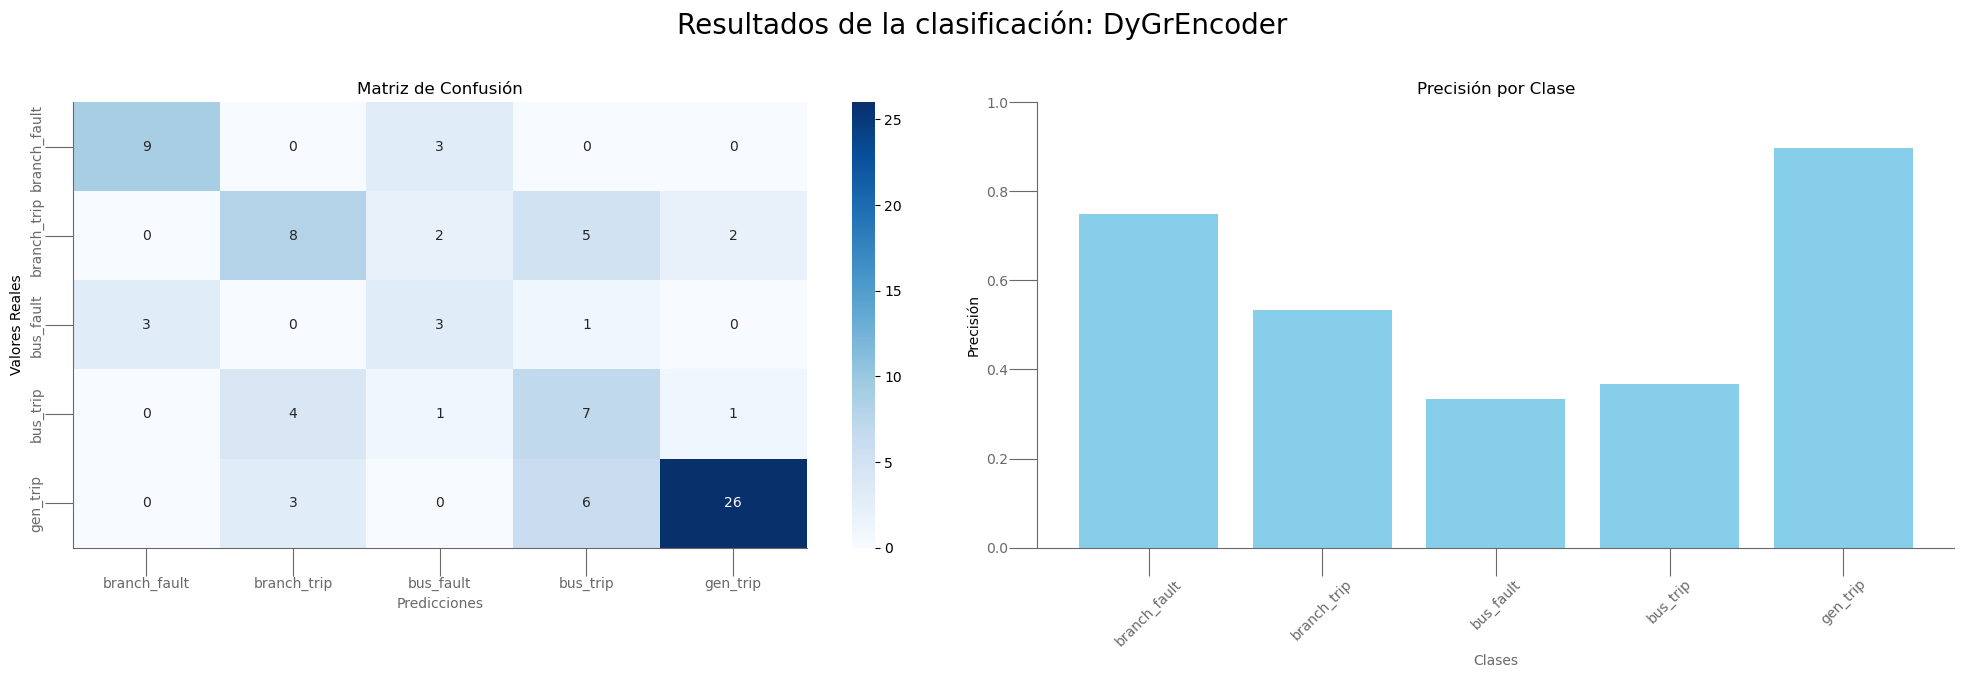

In [75]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "DyGrEncoder")

In [76]:
name_model ="DyGrEncoder"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0     MPNN_LSTM                {'Hidden Size': 64, 'Dropout': 0.2}   
1    LSTM_BATCH                  {'Hidden Size': 150, 'Layers': 1}   
2  LSTM_NOBATCH                  {'Hidden Size': 150, 'Layers': 2}   
3         AGCRN             {'hidden': 50, 'Embedding': 5, 'K': 2}   
4         AGCRN  {'aggr': 'mean', 'conv': 2, 'lstm': 1, 'lstm_o...   

                      Fichero_resultados_experimento  Loss_tst  Loss_eval  \
0  ../experimentos_split/results/clasificacion/aj...  1.348738   1.286855   
1  ../experimentos_split/results/clasificacion/aj...  1.163377   1.213140   
2  ../experimentos_split/results/clasificacion/aj...  1.160608   1.194841   
3  ../experimentos_split/results/clasificacion/aj...  1.344170   1.293829   
4  ../experimentos_split/results/clasificacion/aj...  1.278305   1.244017   

   Loss_final  Accuracy_eval  Precision_eval  Recall